# Energy Consumption Forecast


## Problem Statement
Forecast the electricity consumption of top 3 households with highest number of samples on an hourly basis based on the previous usage pattern. The major features for analysis includes household id, the plans used (standard or dynamic time of use), date, time, meter readings in Kwh and acorn groups.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import seaborn as sns
# from keras_radam.training import RAdamOptimizer

In [4]:
df = pd.read_csv('Power-Networks-LCL.csv')
df.head()

,LCLid,stdorToU,DateTime,KWh,Acorn,Acorn_grouped
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0.0,ACORN-A,Affluent
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0.0,ACORN-A,Affluent
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0.0,ACORN-A,Affluent
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0.0,ACORN-A,Affluent
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0.0,ACORN-A,Affluent


The top 3 households with highest number of samples are extracted.

In [5]:
df = pd.read_csv('Power-Networks-LCL.csv')
# Top 3 Households with highest number of samples
top3 = df.groupby('LCLid').count().sort_values(by=['stdorToU'], ascending=False)[:3]
top3_house_ids = top3.index.values
top3_house_ids

array(['MAC000018', 'MAC000021', 'MAC000020'], dtype=object)

c:\python\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


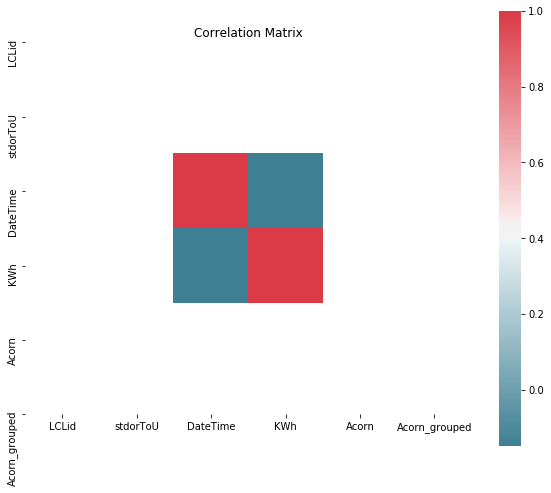

In [6]:
# Lets take a look at how each of the colums relate to each other
temp_df = df[(df['LCLid'] == top3_house_ids[0])]

for dt in temp_df.columns:
        if str(temp_df[dt].dtype) == 'object':
            temp_df[dt] = temp_df[dt].replace(to_replace=temp_df[dt].unique(), value=list(range(len(temp_df[dt].unique()))))
            
f, ax = plt.subplots(figsize=(10, 8))
ax.title.set_text('Correlation Matrix')
corr = temp_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

Other data like Acorn Group are stripped off as they have no relation with the target variable.

In [7]:
def get_data_from_id(df, id):
    temp_df = df[(df['LCLid'] == id)]
    # The columns with same value for each ID are removed
    temp_df = temp_df.drop(columns=['LCLid', 'stdorToU', 'Acorn', 'Acorn_grouped'])
    return temp_df

dfs = list()
total_len = 39078
for id in top3_house_ids:
    dfs.append(get_data_from_id(df, id)[:total_len])

## **Pearson's Correlation**
Person correlation of each series with respect to the other is positive.This implies that *Multiple Parallel Time Series Forecasting* may not be the optimal solution as the weights may generate correlation and eventually lead to Overfiiting. The next optimal solution would be to perform Univariate Time Series Forecast on the data


In [8]:
from scipy.stats import pearsonr
   
comb = [(0, 1), (0, 2), (1, 2)]
print('Pearson Correlation:')
for c in comb:
    corr = pearsonr(dfs[c[0]]['KWh'].values, dfs[c[1]]['KWh'].values)
    print('corr of House{} and House{} = {}'.format(c[0], c[1], corr))

Pearson Correlation:
corr of House0 and House1 = (0.04186040878636812, 1.2484681844331152e-16)
corr of House0 and House2 = (0.062306505781806146, 6.367365023234245e-35)
corr of House1 and House2 = (0.12644943574404027, 5.4014102731926595e-139)


 The problem statement has specified that **hourly** analysis has to be performed.Hence the **timestep** has to be **2** as each data point is recorded for each half hour.

In [9]:
# defining the batch size and number of epochs
epochs = 12
## Timesteps have to be 2 (Refer above cell)
timesteps = 2 
series = 1
batch_size = 32

In [10]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)

    return (max(train_length_values))

length = get_train_length(dfs[0], batch_size, 0.1)
print(length)

35168


In [11]:
upper_train = length + timesteps*2
split_vals = []
for _df in dfs:
    x = _df[0:upper_train]
    x = x['KWh'].values.reshape((-1,1))
    print(x.shape)
    split_vals.append(x)

(35172, 1)
(35172, 1)
(35172, 1)


In [12]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
normalized_vals = list()
for data in split_vals:
    training_set_scaled = sc.fit_transform(np.float64(data))
    normalized_vals.append(training_set_scaled)
    
normalized_vals

[array([[0.10749999],
        [0.056     ],
        [0.065     ],
        ...,
        [0.008     ],
        [0.008     ],
        [0.0075    ]]), array([[0.146593  ],
        [0.093186  ],
        [0.13996316],
        ...,
        [0.10718232],
        [0.10092081],
        [0.09871086]]), array([[0.12644836],
        [0.10428211],
        [0.0906801 ],
        ...,
        [0.0302267 ],
        [0.02972292],
        [0.02216625]])]

In [13]:
def x_y_split(index):
    """Index has to be between 0 and 2 considering top 3 households"""
    X_train = []
    y_train = []

    for i in range(timesteps, length + timesteps): 
        X_train.append(normalized_vals[index][i-timesteps:i,0])
        y_train.append(normalized_vals[index][i:i+timesteps,0])
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (length, timesteps, series))
    y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], series))
    
    return X_train, y_train

In [14]:
## CHANGE INDEX FOR OTHER TWO HOUSEHOLDS
index = 0 # For 1st household
##

X_train, y_train = x_y_split(0)

print(X_train.shape)
print(y_train.shape)

(35168, 2, 1)
(35168, 2, 1)


## Building the model and Training


In [15]:
# Building the model
regressor_mae = tf.keras.Sequential()
regressor_mae.add(tf.keras.layers.CuDNNLSTM(100, stateful=True, return_sequences=True, input_shape=(2, series), batch_size = batch_size))
regressor_mae.add(tf.keras.layers.CuDNNLSTM(100, stateful=True, return_sequences=True))
regressor_mae.add(tf.keras.layers.CuDNNLSTM(100, stateful=True, return_sequences=True))
regressor_mae.add(tf.keras.layers.Dense(1))
regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (32, 2, 100)              41200     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (32, 2, 100)              80800     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (32, 2, 100)              80800     
_________________________________________________________________
dense (Dense)                (32, 2, 1)                101       
Total params: 202,901
Trainable params: 202,901
Non-trainable params: 0
_________________________________________________________________


In [16]:
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1)
    regressor_mae.reset_states()

Epoch: 0
35168/35168 [==============================] - 35s 990us/sample - loss: 0.0414 - loss: 0.041
Epoch: 1
35168/35168 [==============================] - 22s 612us/sample - loss: 0.0336 - loss:
Epoch: 2
35168/35168 [==============================] - 21s 602us/sample - loss: 0.0335
Epoch: 3
35168/35168 [==============================] - 21s 605us/sample - loss: 0.0334
Epoch: 4
35168/35168 [==============================] - 21s 602us/sample - loss: 0.0333
Epoch: 5
35168/35168 [==============================] - 21s 599us/sample - loss: 0.0333
Epoch: 6
35168/35168 [==============================] - 21s 600us/sample - loss: 0.0332
Epoch: 7
35168/35168 [==============================] - 21s 600us/sample - loss: 0.0334
Epoch: 8
35168/35168 [==============================] - 20s 579us/sample - loss: 0.0333
Epoch: 9
35168/35168 [==============================] - 22s 614us/sample - loss: 0.0334
Epoch: 10
35168/35168 [==============================] - 21s 604us/sample - loss: 0.0334 - los - E

In [17]:
def get_test_length(index, batch_size): 
    dataset = dfs[index]
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
    return (max(test_length_values))

In [18]:
test_length = get_test_length(index, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

39044
3872


In [19]:
#subsetting
def get_test_data(index):
    df_test = dfs[index][upper_train:upper_test] 
    test_set = df_test['KWh'].values.reshape(-1,1)

    #scaling
    scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

    #creating input data
    X_test = []
    for i in range(timesteps, testset_length + timesteps):
         X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
    X_test = np.array(X_test)

    #reshaping
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_test, test_set

X_test, test_set = get_test_data(index)

In [20]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

# reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print(predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(3872, 2, 1)
(3872, 2)
(3870, 1)


## Visualising the results


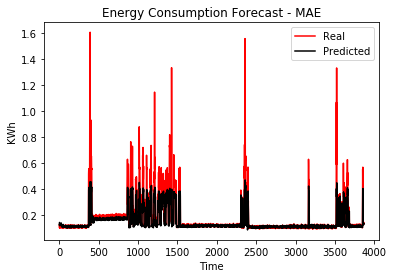

In [21]:
plt.plot(test_set[timesteps:len(y_test)], color = 'red', label = 'Real')
plt.plot(y_test[0:len(y_test) - timesteps], color = 'black', label = 'Predicted')
plt.title('Energy Consumption Forecast - MAE')
plt.xlabel('Time')
plt.ylabel('KWh')
plt.legend()
plt.show()

## Evaluation Metrics

In [22]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

0.0810033884240954


In [23]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

0.027453096295859628


In [24]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mse)

0.006561548936184871
